## *Prep*

In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from collections import Counter

# The following five lines ensure that we reload the 
# preprocessing functions everytime this cell is called
import importlib
import helper_files.preprocessing as preprocFuncts
import helper_files.util as util
import parameters as MyParams
importlib.reload(preprocFuncts)
importlib.reload(util)
importlib.reload(MyParams)

# MODEL PARAMETERS
K_NEIGHBORS = 20

# DERIVATION PARAMETERS
WINDOW_LEN = MyParams.WINDOW_LEN # measured in IQ samples
OVERLAP = MyParams.OVERLAP
NUM_FEATURES = MyParams.NUM_FEATURES

# DATA PARAMETERS
NUM_TRAINING_FILES = MyParams.NUM_TRAINING_FILES # how many files in the saved numpy data for training
NUM_EVALUATION_FILES = MyParams.NUM_EVALUATION_FILES # how many files in the saved numpy data for evaluation
MAX_FILES = MyParams.MAX_FILES # if not using the saved numpy data, this is the max files to intake
USE_SAVED_DATA = MyParams.USE_SAVED_DATA # True = used the saved .npy file data instead of re-deriving the features again
SAVE_METRICS_TO_FILE = MyParams.SAVE_METRICS_TO_FILE
TRAINING_DATASET = MyParams.TRAINING_DATASET
EVAL_DATASET = MyParams.EVAL_DATASET

FEATURES_TO_USE = MyParams.FEATURES_TO_USE

## *Loading training dataset*

In [2]:
importlib.reload(preprocFuncts)
importlib.reload(util)
importlib.reload(MyParams)

# carlos' Mac
# data_dir = '/Users/carlos_1/Documents/GitHub/RFML-Code/RFML_Combined_Dataset_2025/RFML_Drone_Dataset_2025/old_drone_full_annotated_dataset/RFML_Old_Drone_Training_Dataset/*'
# uav-cyberlab-rfml laptop
data_dir = f'/home/uav-cyberlab-rfml/RFML/test_{TRAINING_DATASET}_training'
print("Pulling from directory: ", data_dir)

training_derived_samples, training_labels = preprocFuncts.preprocessFiles(
    data_dir, 
    postfix=f"train_{NUM_FEATURES}ftrs_{NUM_TRAINING_FILES}files_{WINDOW_LEN}win_{'0' + str(int(OVERLAP * 100))}over{"_"+TRAINING_DATASET if TRAINING_DATASET != "" else ""}", 
    features_to_use=FEATURES_TO_USE,
    window_len=WINDOW_LEN,
    overlap=OVERLAP,
    saved_data=USE_SAVED_DATA, 
    max_files=MAX_FILES,
)

Pulling from directory:  /home/uav-cyberlab-rfml/RFML/test_dji_20mhz_comms_training
Using the saved data:
	./saved-data/X_train_5ftrs_25files_4096win_050over_dji_20mhz_comms.npy
	./saved-data/y_train_5ftrs_25files_4096win_050over_dji_20mhz_comms.npy


## *Preprocessing training dataset*

The following cell removes labels that should not be used---like annotations that were not labeled, or the 'Burst' label, or the Ruko F11 pro labels because it does not appear in the evaluation dataset. 

The cell also applies an encoder to the labels to use for fitting and predicting.

In [3]:
print("\n==BEFORE BALANCING========")
util.display(training_derived_samples, training_labels)

training_derived_samples, training_labels = preprocFuncts.balanceByMedian(training_derived_samples, training_labels, unlabeled_downsampling=70_000)

print("\n==AFTER BALANCING========")
util.display(training_derived_samples, training_labels)



X_train = training_derived_samples
y_train = training_labels

print(f"Number of total samples: {X_train.shape[0]:,}")

remove_labels = [
    'Burst',
    '',
    # 'Ruko_F11_pro_UL',
    # 'HS100_Downlink',
]

# Build mask: True = keep, False = remove
mask = ~np.isin(y_train, remove_labels)

# Apply mask
X_train = X_train[mask]
y_train = y_train[mask]
y_train_strings = y_train

print(f"\nAfter removing unnecessary labels:")
print(f"Number of total samples: {X_train.shape[0]:,}")


==BEFORE BALANCING========

Number of labels: 854,448
Number of samples: 854,448

Shape of labels: (854448,)
Shape of samples: (854448, 5)

One sample: 
[7.5714419e+05 7.5725062e+05 1.0863329e+03 2.5407424e+13 2.5502678e+01]

The counts:
12,394   "Bluetooth"
158,150  "Ocusync_2.0_mini_4k_DL"
98,162   "Ocusync_2.0_mini_4k_UL"
23,134   "WIFI"
562,608  "background_noise"

==AFTER BALANCING========

Number of labels: 350,000
Number of samples: 350,000

Shape of labels: (350000,)
Shape of samples: (350000, 5)

One sample: 
[2.3840665e+02 2.2074677e+02 1.9238884e+01 8.0249155e+09 1.1769520e+03]

The counts:
70,000   "Bluetooth"
70,000   "Ocusync_2.0_mini_4k_DL"
70,000   "Ocusync_2.0_mini_4k_UL"
70,000   "WIFI"
70,000   "background_noise"
Number of total samples: 350,000

After removing unnecessary labels:
Number of total samples: 350,000


## *Loading evaluation dataset*

In [4]:
importlib.reload(preprocFuncts)
importlib.reload(util)
importlib.reload(MyParams)

# carlos' Mac
# data_dir = '/Users/carlos_1/Documents/GitHub/RFML-Code/RFML_Combined_Dataset_2025/RFML_Drone_Dataset_2025/old_drone_full_annotated_dataset/RFML_Old_Drone_Eval_data/*'
# uav-cyberlab-rfml laptop
data_dir = f'/home/uav-cyberlab-rfml/RFML/test_{EVAL_DATASET}_eval'
print("Pulling from directory: ", data_dir)


test_derived_samples, test_labels = preprocFuncts.preprocessFiles(
    data_dir, 
    postfix=f"eval_{NUM_FEATURES}ftrs_{NUM_EVALUATION_FILES}files_{WINDOW_LEN}win_{'0' + str(int(OVERLAP * 100))}over{"_"+EVAL_DATASET if EVAL_DATASET != "" else ""}", 
    features_to_use=FEATURES_TO_USE,
    window_len=WINDOW_LEN,
    overlap=OVERLAP,
    saved_data=USE_SAVED_DATA, 
    max_files=MAX_FILES,
)

Pulling from directory:  /home/uav-cyberlab-rfml/RFML/test_dji_20mhz_comms_eval
Using the saved data:
	./saved-data/X_eval_5ftrs_6files_4096win_050over_dji_20mhz_comms.npy
	./saved-data/y_eval_5ftrs_6files_4096win_050over_dji_20mhz_comms.npy


## *Preprocessing evaluation dataset*
First I need to remove labels that were in the evaluation set but not in the training set.

In [5]:
print("\n==BEFORE BALANCING========")
util.display(test_derived_samples, test_labels)

test_derived_samples, test_labels = preprocFuncts.balanceByMedian(test_derived_samples, test_labels, unlabeled_downsampling=7_000)
print("\n==AFTER BALANCING========")
util.display(test_derived_samples, training_labels)



X_test = test_derived_samples
y_test = test_labels


print(f"Number of total samples: {X_test.shape[0]:,}")

# remove labels that are in the y_test but not in y_train
remove_labels = np.setdiff1d(y_test, y_train_strings).tolist()
print("Removing the following labels:\n" + "\n".join(remove_labels))

# Build mask: True = keep, False = remove
mask = ~np.isin(y_test, remove_labels)

# Apply mask
X_test = X_test[mask]
y_test = y_test[mask]

print(f"\nAfter removing unnecessary labels:")
print(f"Number of total samples: {X_test.shape[0]:,}")

y_strings = y_test # store the string version of the labels before they get encoded


==BEFORE BALANCING========

Number of labels: 213,612
Number of samples: 213,612

Shape of labels: (213612,)
Shape of samples: (213612, 5)

One sample: 
[3.9581367e+03 3.8779756e+03 7.8478233e+01 1.3160687e+11 1.1243217e+03]

The counts:
4,906    "Bluetooth"
7,159    "Burst"
19,160   "Ocusync_2.0_mini_4k_DL"
20,965   "Ocusync_2.0_mini_4k_UL"
5,865    "WIFI"
155,557  "background_noise"

==AFTER BALANCING========

Number of labels: 350,000
Number of samples: 42,474

Shape of labels: (350000,)
Shape of samples: (42474, 5)

One sample: 
[5.1638638e+05 5.1634594e+05 9.6209412e+02 1.7328395e+13 6.2738580e+02]

The counts:
70,000   "Bluetooth"
70,000   "Ocusync_2.0_mini_4k_DL"
70,000   "Ocusync_2.0_mini_4k_UL"
70,000   "WIFI"
70,000   "background_noise"
Number of total samples: 42,474
Removing the following labels:
Burst

After removing unnecessary labels:
Number of total samples: 35,395


## *Fitting and prediction*

In [6]:
from sklearn.neighbors import KNeighborsClassifier

train_classes = set(np.unique(y_train))
test_classes  = set(np.unique(y_test))

print("Train classes:", len(train_classes))
print("Test classes :", len(test_classes))
print("Overlap      :", len(train_classes & test_classes))
print("Only-in-test :", sorted(test_classes - train_classes)[:20])
print("Only-in-train:", sorted(train_classes - test_classes)[:20])


# Scaling
knn_class = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=K_NEIGHBORS))
])

# Fitting
knn_class.fit(X_train, y_train)
y_proba = knn_class.predict(X_test)


Train classes: 5
Test classes : 5
Overlap      : 5
Only-in-test : []
Only-in-train: []


## *Metrics*

In [7]:
importlib.reload(preprocFuncts)
importlib.reload(util)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


base_name='knn'
model="K-Nearest Neighbors"

accuracy = accuracy_score(y_test, y_proba)
perc_accuracy = accuracy * 100
cr = classification_report(y_test, y_proba)
cm = confusion_matrix(y_test, y_proba)

util.printMetrics(
    base_name=base_name + "_metrics", 
    model=model, 
    perc_accuracy=perc_accuracy, 
    notes=f"K_NEIGHBORS = {K_NEIGHBORS}",
    cr=cr,
    cm=cm,
    labels=y_strings,
    max_files=MAX_FILES,
    window_size=WINDOW_LEN,
    overlap=OVERLAP,
    num_features=NUM_FEATURES,
    num_training_files=NUM_TRAINING_FILES,
    num_evaluation_files=NUM_EVALUATION_FILES,
    training_dataset=TRAINING_DATASET,
    eval_dataset=EVAL_DATASET,
)


if SAVE_METRICS_TO_FILE: 
    util.saveMetricsToFile(
        base_name=base_name + "_metrics", 
        model=model, 
        perc_accuracy=perc_accuracy, 
        notes=f"K_NEIGHBORS = {K_NEIGHBORS}",
        cr=cr,
        cm=cm,
        labels=y_strings,
        max_files=MAX_FILES,
        window_size=WINDOW_LEN,
        overlap=OVERLAP,
        num_features=NUM_FEATURES,
        num_training_files=NUM_TRAINING_FILES,
        num_evaluation_files=NUM_EVALUATION_FILES,
        training_dataset=TRAINING_DATASET,
        eval_dataset=EVAL_DATASET,
    )

Model: K-Nearest Neighbors
Accuracy: 40.89%
Date: 2026-02-14 00:54:22.878604
Training Dataset: dji_20mhz_comms
Evaluation Dataset: dji_20mhz_comms
Notes: K_NEIGHBORS = 20

=========PARAMETERS=========
WINDOW_LEN = 4,096
OVERLAP = 0.5
NUM_FEATURES = 5
NUM_TRAINING_FILES = 25
NUM_EVALUATION_FILES = 6

Count	Label
7,079	Bluetooth
7,079	WIFI
7,079	Ocusync_2.0_mini_4k_UL
7,079	Ocusync_2.0_mini_4k_DL
7,079	background_noise

Classification Report:
                        precision    recall  f1-score   support

             Bluetooth       0.49      0.42      0.45      7079
Ocusync_2.0_mini_4k_DL       0.32      0.62      0.43      7079
Ocusync_2.0_mini_4k_UL       0.52      0.43      0.47      7079
                  WIFI       0.03      0.00      0.01      7079
      background_noise       0.47      0.57      0.52      7079

              accuracy                           0.41     35395
             macro avg       0.36      0.41      0.37     35395
          weighted avg       0.36      0.

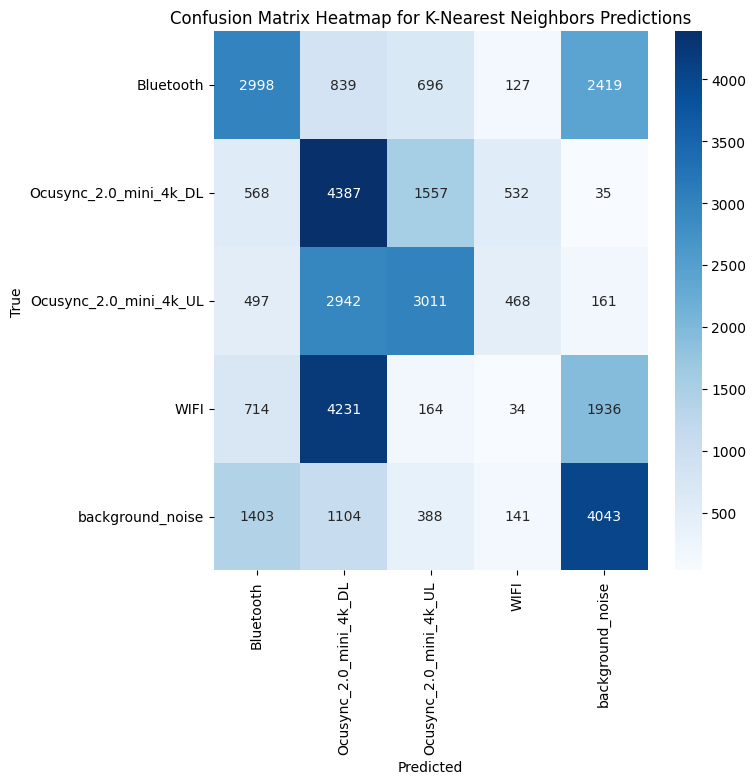

In [8]:
# Create a heatmap of the confusion matrix

plt.figure(figsize=(7, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_strings), yticklabels=np.unique(y_strings))

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix Heatmap for {model} Predictions')

if SAVE_METRICS_TO_FILE:
    plt.savefig(f"./metrics/{base_name}_cm_{(perc_accuracy * 100):.0f}.png", bbox_inches='tight', dpi=200)
plt.show()


The following cell prints Cohen's Kappa and Matthew's Correlation Coefficient
* Cohen's Kappa (κ) is a statistic measuring agreement between two categorical raters (or one rater at two times) beyond what's expected by chance, correcting for random agreement, and is used for inter-rater reliability in fields like machine learning. It ranges from -1 (total disagreement) to +1 (perfect agreement), with 0 meaning agreement is purely random.

* The Matthews Correlation Coefficient (MCC) is a robust metric in machine learning for evaluating binary/multiclass classification, measuring correlation between actual and predicted classes, ranging from -1 (perfect inverse) to +1 (perfect prediction), with 0 being random; it's especially valuable for imbalanced datasets as it uses all four confusion matrix values (TP, TN, FP, FN) for a balanced performance score, unlike simpler metrics that can be misleading.

In [9]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

print("Cohen's Kappa:", cohen_kappa_score(y_test, y_proba))
print("MCC:", matthews_corrcoef(y_test, y_proba))


Cohen's Kappa: 0.26112445260630035
MCC: 0.2721172160608672
